# Analysis of intervention measures

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
import numpy as np
import seaborn as sns

In [2]:
src = '../data/simulation_results/ensembles'

In [81]:
results = pd.DataFrame()

for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])
    
results = results.reset_index(drop=True)
# subtract the index case
results['infected_agents'] = results['infected_agents'] - 1
results['Höhrsaalbelegung'] = results['presence_fraction'] * 100
results['Höhrsaalbelegung'] = results['Höhrsaalbelegung'].astype(int)
results['Höhrsaalbelegung'] = results['Höhrsaalbelegung'].apply(lambda x: '{}%'.format(x))
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])

In [82]:
results['scenario'] = np.nan
results.loc[(0, 0, slice(None)), 'scenario'] = 'keine Masken'
results.loc[(1, 1, slice(None)), 'scenario'] = 'alle Masken'
results.loc[(1, 0, slice(None)), 'scenario'] = 'nur Studierende Masken'
results.loc[(0, 1, slice(None)), 'scenario'] = 'nur Lehrende Masken'
results = results.reset_index()

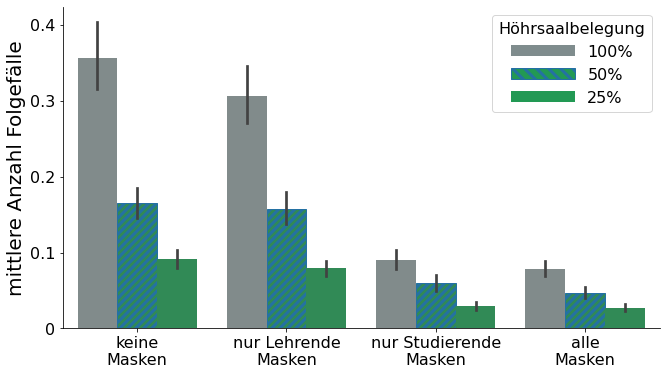

In [113]:
import matplotlib.patches as mpatches
green = '#229954'
blue = '#2471A3'
grey = '#7F8C8D'

plt.rcParams['hatch.linewidth'] = 3
order = ['keine Masken', 'nur Lehrende Masken', 'nur Studierende Masken', 'alle Masken']
g = sns.catplot(x='scenario', y='infected_agents',
                hue='Höhrsaalbelegung', data=results, kind="bar", aspect=1.8,
                order=order, legend=False, palette=[grey, green, green])
ax = g.axes[0][0]
ax.set_ylabel('mittlere Anzahl Folgefälle', fontsize=20)
ax.set_xlabel('')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
ax.set_xticklabels(['keine\nMasken', 'nur Lehrende\nMasken', 
                    'nur Studierende\nMasken', 'alle\nMasken'], fontsize=16)

for i in [4, 5, 6, 7]:
    bar = ax.patches[i]
    hatch = '///'
    bar.set_hatch(hatch)
    bar.set_edgecolor(blue)
    
patch1 = mpatches.Patch(facecolor=grey,label='100%')
patch2 = mpatches.Patch(facecolor=green, hatch='\\\\',label='50%', edgecolor=blue)
patch3 = mpatches.Patch(facecolor=green, label='25%')

legend = ax.legend(handles = [patch1, patch2, patch3], loc=1, fontsize=16, 
          title='Höhrsaalbelegung', handlelength=4)
plt.setp(legend.get_title(),fontsize=16);

In [84]:
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])

In [91]:
results.loc[0, 0, 1]['infected_agents'].quantile(0.90)

<ipython-input-91-21b990a76895>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1]['infected_agents'].quantile(0.90)


1.0

In [89]:
results.loc[0, 0, 1]['infected_agents'].quantile(0.99)

<ipython-input-89-7f606fa50f44>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1]['infected_agents'].quantile(0.99)


6.0

In [90]:
results.loc[0, 0, 1]['infected_agents'].max()

<ipython-input-90-bcc560fe58f8>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1]['infected_agents'].max()


36.0

<ipython-input-92-eb7530ddb6cc>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.hist(results.loc[0, 0, 1]['infected_agents'], bins=range(0, 20, 2), rwidth=0.8)


(array([4.682e+03, 1.900e+02, 6.400e+01, 2.500e+01, 1.400e+01, 9.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]),
 <BarContainer object of 9 artists>)

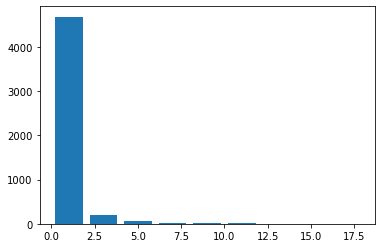

In [92]:
fig, ax = plt.subplots()
ax.hist(results.loc[0, 0, 1]['infected_agents'], bins=range(0, 20, 2), rwidth=0.8)